# Gaussian Process Regression

In [25]:
import numpy as np
import matplotlib.pyplot as mplt
#import ipywidgets as widgets  # only needed for isosurfaces, comment out if you don't have it installed
#import ipyvolume as ipv # only needed for isosurfaces, comment out if you don't have it installed
%matplotlib inline
np.seterr(all='ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

In [2]:
N = 128                           # we discretize our volume using N**3 cells
L = 1.0                           # the box size, sets the fundamental mode

# create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N,N,N])

kmin = 2.0*np.pi/L # the fundamental mode of the box
kmax = kmin * N/2     # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

# now 'kv' is the k vector, and 'kmod' its modulus at every point

alpha = 3.0
norm  = 1.0/(2.0*np.pi)**(-1.5)
# the matter power spectrum is the product of primordial spectrum and T**2
def P(k):
    return k**(-alpha)*norm

In [3]:
# generate a complex random field
fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean

# compute (Fast) Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# re-normalise (should be done using filtered variance)
f = f / np.std(f.flatten())

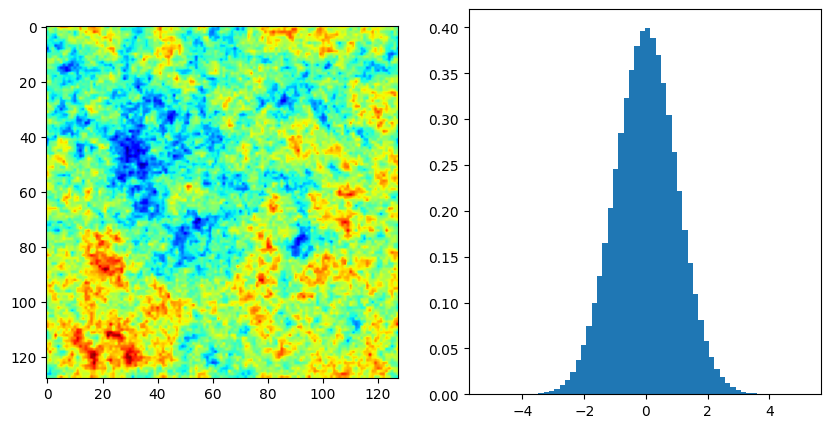

In [4]:
fig, ax = mplt.subplots(1,2,figsize=[10,5])
ax[0].imshow(f[...,N//2], cmap='jet')
ax[1].hist(f.flatten(),bins=60,density=True);

In [56]:
def delta_dirac(x, sig):
    val = np.zeros_like(x)
    val[(-(1/(2*sig))<=x) & (x<=(1/(2*sig)))] = 1
    return val

def kronecker_delta(ki, kj):
    if ki == kj:
        return 1
    else:
        return 0

def covariance(ki, kj):
     return (2.0 * np.pi)**3 * P(ki)

In [26]:
sample_size = 100

# Create a 1D array of coordinates for samples
x = np.linspace(0, L, sample_size)

# Reshape your existing random field 'f' into a 1D array
f_1d = f.flatten()

# Define the kernel (covariance function)
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e2))

# Initialize the Gaussian Process Regressor
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP to your existing samples
gp.fit(x[:, np.newaxis], f_1d)

# Generate new points (e.g., 100 points) from the GP posterior
x_new = np.linspace(0, L, 100)
f_new_mean, f_new_std = gp.predict(x_new[:, np.newaxis], return_std=True)

# Sample from the GP posterior (you can adjust the number of samples)
num_samples = 10
f_samples = gp.sample_y(x_new[:, np.newaxis], n_samples=num_samples)

# 'f_new_mean' represents the mean of the GP posterior
# 'f_new_std' represents the standard deviation of the GP posterior
# 'f_samples' contains multiple samples from the GP posterior

# You can use 'f_new_mean' and 'f_new_std' to visualize the GP regression
# and 'f_samples' to sample the Gaussian random field.

# Remember to adjust hyperparameters (e.g., kernel parameters) as needed.

# Note: This is a simplified example. In practice, you might want to optimize
# hyperparameters and handle edge cases more carefully.


ValueError: Found input variables with inconsistent numbers of samples: [100, 2097152]

C:\Users\AltonV\AppData\Local\Temp\ipykernel_4940\3025366061.py:43: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(mean, covariance, n_samples)


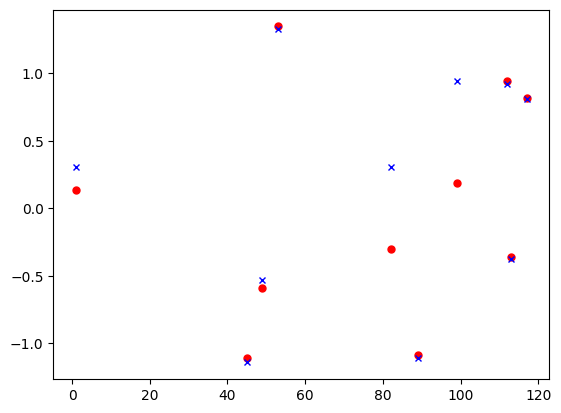

(10, 3)
[-0.5912312458648462, 1.3473866405317558, -1.1095269272804058, 0.188736344295941, 0.13573635072158838, 0.817473782857603, 0.9455943660778795, -1.0852164630138414, -0.36400967748478497, -0.304577459360412]
(3, 10)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Parameters
N = 128                           # We discretize our volume using N**3 cells
L = 1.0                           # The box size, sets the fundamental mode
alpha = 3.0                       # Power spectrum exponent
norm = 1.0 / (2.0 * np.pi)**(-1.5)

# Create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N, N, N])

kmin = 2.0 * np.pi / L            # The fundamental mode of the box
kmax = kmin * N / 2               # The Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N, d=1.0 / kmin / N)  # Get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d, k1d, k1d)   # Turn this into 3 3D fields giving kx, ky, kz for each point
kmod = np.sqrt(kv[0]**2 + kv[1]**2 + kv[2]**2)  # Get norm k for each point

# Define the power spectrum function
def P(k):
    return k**(-alpha) * norm

# Generate a complex random field
fk = np.random.normal(size=(N, N, N)) + 1j * np.random.normal(size=(N, N, N))
fk = fk * np.sqrt(P(kmod))  # Impose power spectrum 
fk[0, 0, 0] = 0.0  # Zero f(k=0) to enforce zero mean

# Compute (Fast) Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# Re-normalize
f = f / np.std(f.flatten())

# Gaussian Process Regression
def covariance_function(x1, x2, length_scale=0.1, sigma_f=1.0):
    """ Squared Exponential kernel (covariance function) """
    sqdist = cdist(x1, x2, 'sqeuclidean')
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

def sample_gp(mean, covariance, n_samples=1):
    """ Sample from a Gaussian process with given mean and covariance """
    return np.random.multivariate_normal(mean, covariance, n_samples)

# Sample points and observations
n_obs = 10
sample_points = np.random.randint(0, N, size=(n_obs, 3))
# sample_values = np.random.normal(size=n_obs) # Use your existing random field 'f'
sample_values = [f[x[0],x[1],x[2]] for x in sample_points]

# Covariance matrices
K = covariance_function(sample_points, sample_points)
K_s = covariance_function(sample_points, sample_points)
K_ss = covariance_function(sample_points, sample_points) + 1e-8 * np.eye(n_obs)

# Mean and covariance for the posterior
K_inv = np.linalg.inv(K + 1e-8 * np.eye(n_obs))
mu_s = K_s.T @ K_inv @ sample_values
cov_s = K_ss - K_s.T @ K_inv @ K_s

# Alternative way to compute the covariance matrix
cov_s2 = np.zeros((n_obs, n_obs))
for i in range(n_obs):
    for j in range(n_obs):
        cov_s2[i,j] = covariance(f[sample_points[i][0], sample_points[i][1], sample_points[i][2]], f[sample_points[j][0], sample_points[j][1], sample_points[j][2]]) / N**3
cov_s2 = np.diagonal(cov_s2) * np.eye(n_obs)

# Sample from the posterior
samples = sample_gp(mu_s, cov_s2, n_samples=3)

# Plot one of the samples (for 3D visualization, choose an appropriate tool)
plt.figure()
plt.plot(sample_points[:, 0], sample_values, 'ro', markersize=5)
plt.plot(sample_points[:, 0], samples[2], 'bx', markersize=5)
plt.show()

print(sample_points.shape)
print(sample_values)
print(samples.shape)

# Note: Visualization of the 3D field requires appropriate 3D plotting techniques/tools


In [8]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

# Parameters
N = 128  # we discretize our volume using N**3 cells
L = 1.0  # the box size, sets the fundamental mode

# Create a Gaussian random field of size N**3
delta0 = np.random.normal(size=[N, N, N])

kmin = 2.0 * np.pi / L  # the fundamental mode of the box
kmax = kmin * N / 2  # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N, d=1.0 / kmin / N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d, k1d, k1d)  # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2 + kv[1]**2 + kv[2]**2)  # get norm k for each point

# Now 'kv' is the k vector, and 'kmod' its modulus at every point

alpha = 3.0
norm = 1.0 / (2.0 * np.pi)**(-1.5)

# The matter power spectrum is the product of primordial spectrum and T**2
def P(k):
    return k**(-alpha) * norm

# Generate a complex random field
fk = np.random.normal(size=(N, N, N)) + 1j * np.random.normal(size=(N, N, N))
fk = fk * np.sqrt(P(kmod))  # impose power spectrum
fk[0, 0, 0] = 0.0  # zero f(k=0) to enforce zero mean

# Compute (Fast) Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# Re-normalise (should be done using filtered variance)
f = f / np.std(f.flatten())

# Define some sample points and their values
# Here we'll randomly sample some points and use the values from f
num_samples = 100  # Number of sample points
sample_points = np.random.randint(0, N, size=(num_samples, 3))
sample_values = f[sample_points[:, 0], sample_points[:, 1], sample_points[:, 2]]

# Convert sample points to a scaled format suitable for GPR
sample_points_scaled = sample_points / N  # Scale points to [0, 1]

# Define the kernel: constant kernel times RBF kernel
# You may need to adjust the kernel parameters based on your specific problem
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e1))
# kernel = C

# Create the GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to the sample data
gp.fit(sample_points_scaled, sample_values)

# Generate a grid of points where we want to predict the field
grid_points = np.array(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N), np.linspace(0, 1, N))).T.reshape(-1, 3)

# Predict the mean and standard deviation at the grid points
mean_prediction, std_prediction = gp.predict(grid_points, return_std=True)

# Reshape the predictions to a 3D field
mean_field = mean_prediction.reshape(N, N, N)
std_field = std_prediction.reshape(N, N, N)

# Display or further use mean_field and std_field as needed


InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <function C at 0x000002711EC88180> instead.